In [131]:
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap
from sklearn.decomposition import PCA
import importlib
importlib.reload(imd_nd_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [86]:

def get_udr(mat):
    mat = np.abs(mat)
    return (((mat.max(axis=0)**2)/mat.sum(axis=0)).sum() + ((mat.max(axis=1)**2)/mat.sum(axis=1)).sum())/np.sum(mat.shape)

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [4]:
X = get_truncated_lorenz_rand(400,n_steps=20000,)

observables = StandardScaler().fit_transform(X)

In [63]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),10), np.linspace(X[:,2].min(),X[:,2].max(),10))).reshape(2,-1).T

In [64]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]

In [65]:

observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=8) for e in exp_kernel_grid]) for x in X_]).T
#observables[observables < 0.1] = 0
mixing_mat = np.random.normal(size=(observables.shape[1],observables.shape[1]))
observables = observables @ mixing_mat
observables = StandardScaler().fit_transform(observables)


In [28]:

observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*observables.shape[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


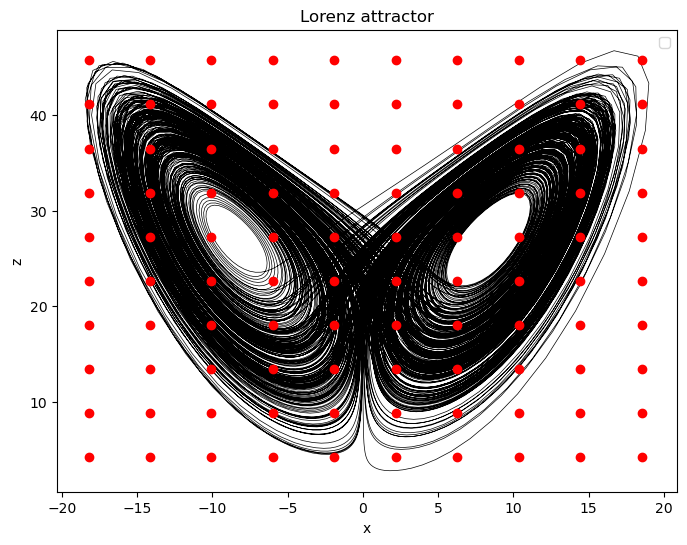

In [66]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=0.5)
plt.scatter(*exp_kernel_grid.T,color="red",zorder=100)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor")
plt.legend()

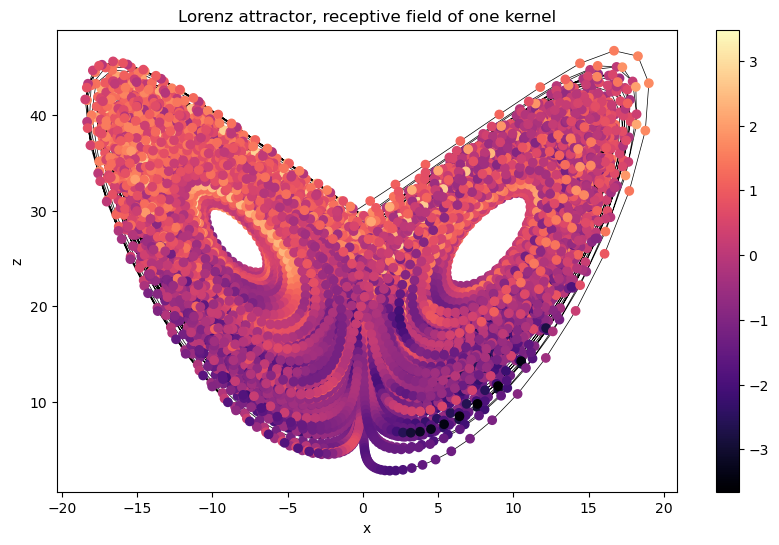

In [67]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=0.5)
plt.scatter(X_[0][:,0],X_[0][:,1],c=observables[:,26],zorder=100,cmap="magma")
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor, receptive field of one kernel")
plt.colorbar()

Text(0, 0.5, 'Observation')

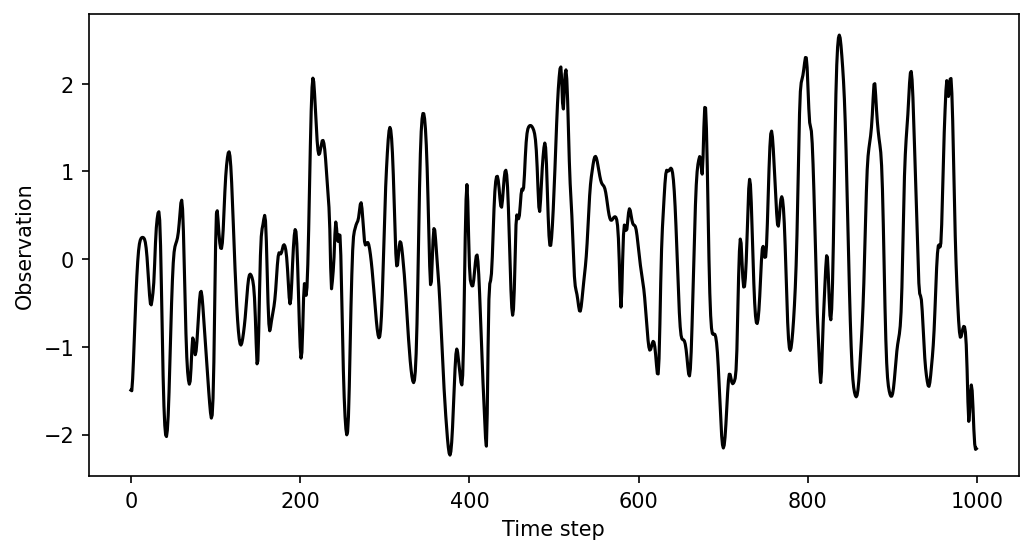

In [68]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(observables[:1000,26],color="black")
plt.xlabel("Time step")
plt.ylabel("Observation")

Text(0.5, 0, 'Time step')

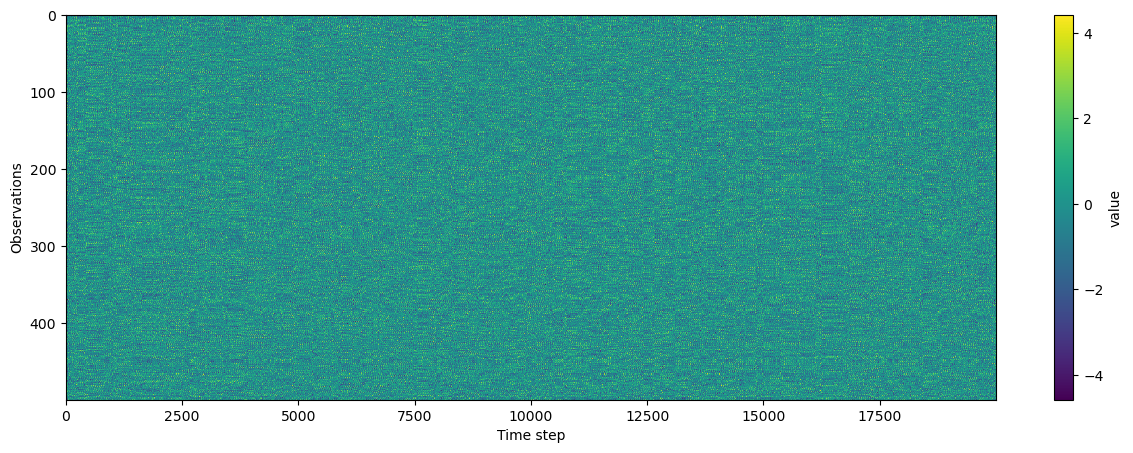

In [69]:
plt.figure(figsize=(15,5))
plt.imshow(observables.T,aspect="auto",interpolation="nearest")
plt.colorbar(label="value")
plt.ylabel("Observations")
plt.xlabel("Time step")

In [70]:
noise_levels = [0.1, 0.2, 0.4, 1, 1.5, 2, 3]

In [110]:
final_losses = []
final_ccm = []

for nl in noise_levels:
    for exp in range(10):
        print(nl, exp)
        eps = np.random.normal(0,nl,size=observables.shape)
        obs = observables.copy()
        obs += eps

        trainer = imd_nd_smap.IMD_nD_smap(obs.shape[1], embed_dim=10, n_components=5, subtract_corr=True, device="cuda")

        trainer.fit(obs, sample_len=150, library_len=800, 
            exclusion_rad=30, theta=8, tp=30, 
            epochs=500, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=3)
        
        final_losses += [trainer.get_loss_history().copy()]

        obs -= eps
        
        unmixed = trainer.predict(obs)

        ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
            np.transpose(unmixed, axes=(1, 0, 2)),
            X_,
            1500, 400, 60,0,
            method="simplex",
            nbrs_num=15,
        ).mean(axis=0)

        final_ccm += [ccm_matrix_unmixed]

0.1 0
Epoch 1/500, Loss: 1.1200
Epoch 2/500, Loss: 1.1355
Epoch 3/500, Loss: 1.0685
Epoch 4/500, Loss: 1.0063
Epoch 5/500, Loss: 0.9415
Epoch 6/500, Loss: 0.8934
Epoch 7/500, Loss: 0.8239
Epoch 8/500, Loss: 0.7844
Epoch 9/500, Loss: 0.7335
Epoch 10/500, Loss: 0.7196
Epoch 11/500, Loss: 0.6821
Epoch 12/500, Loss: 0.6671
Epoch 13/500, Loss: 0.6435
Epoch 14/500, Loss: 0.6047
Epoch 15/500, Loss: 0.6111
Epoch 16/500, Loss: 0.5881
Epoch 17/500, Loss: 0.6048
Epoch 18/500, Loss: 0.5635
Epoch 19/500, Loss: 0.5740
Epoch 20/500, Loss: 0.5203
Epoch 21/500, Loss: 0.5478
Epoch 22/500, Loss: 0.5427
Epoch 23/500, Loss: 0.5382
Epoch 24/500, Loss: 0.5229
Epoch 25/500, Loss: 0.5176
Epoch 26/500, Loss: 0.5370
Epoch 27/500, Loss: 0.5282
Epoch 28/500, Loss: 0.4940
Epoch 29/500, Loss: 0.5154
Epoch 30/500, Loss: 0.4823
Epoch 31/500, Loss: 0.4837
Epoch 32/500, Loss: 0.4942
Epoch 33/500, Loss: 0.4886
Epoch 34/500, Loss: 0.4798
Epoch 35/500, Loss: 0.4818
Epoch 36/500, Loss: 0.4793
Epoch 37/500, Loss: 0.4663
Epoc

In [115]:
udr = np.array(([get_udr(np.abs(i)) for i in final_ccm])).reshape(7,10)
udr_ = np.array(([get_udr(np.abs(i)) for i in final_ccm_])).reshape(7,10)

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_281838/4165783222.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("Relative Noise Level ($\sigma_{noise}$ / $\sigma_{signal}$)")


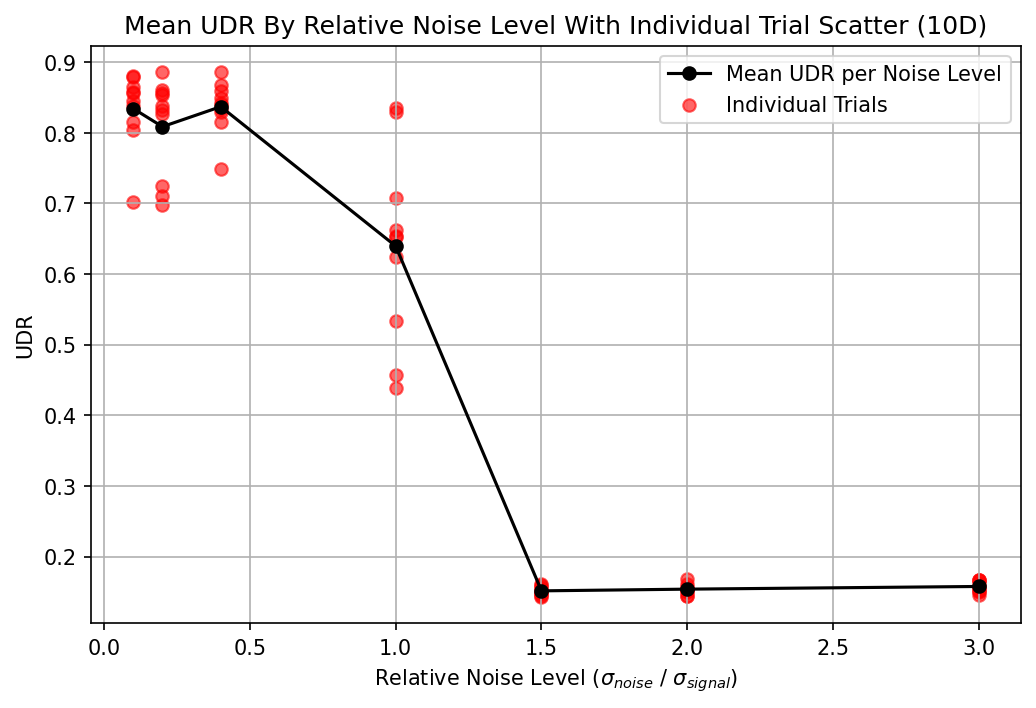

In [130]:

num_groups = udr.shape[0]
num_trials = udr.shape[1]
means = udr.mean(axis=1)
trial_points = [udr[i, :] for i in range(num_groups)]

# Create line plot
fig, ax = plt.subplots(figsize=(8, 5),dpi=150)

# Line plot for group means with relative noise amplitude as x-values
ax.plot(noise_levels, means, marker='o', color='black', label='Mean UDR per Noise Level', linestyle='-')

# Scatter plot for individual trials around each line point
for i in range(num_groups):
    ax.scatter([noise_levels[i]] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xlabel("Relative Noise Level ($\sigma_{noise}$ / $\sigma_{signal}$)")
ax.set_ylabel("UDR")
ax.set_title("Mean UDR By Relative Noise Level With Individual Trial Scatter (10D)")
ax.legend()
plt.grid()
plt.show()



<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_281838/3722930200.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("Relative Noise Level ($\sigma_{noise}$ / $\sigma_{signal}$)")


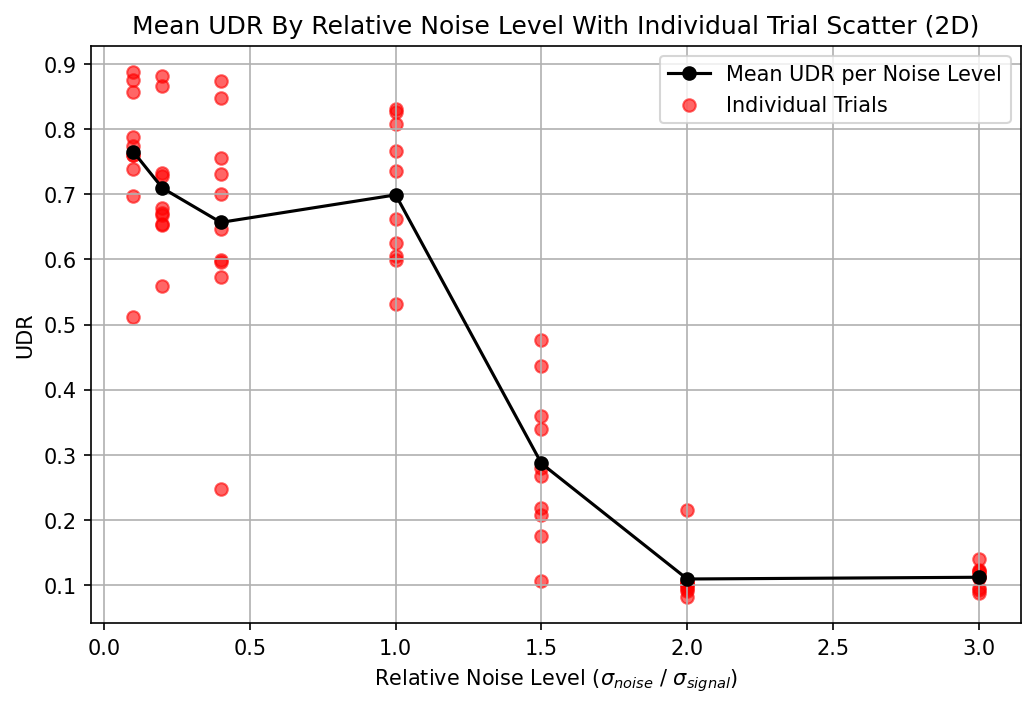

In [129]:

num_groups = udr.shape[0]
num_trials = udr.shape[1]
means = udr_.mean(axis=1)
trial_points = [udr_[i, :] for i in range(num_groups)]

# Create line plot
fig, ax = plt.subplots(figsize=(8, 5),dpi=150)

# Line plot for group means with relative noise amplitude as x-values
ax.plot(noise_levels, means, marker='o', color='black', label='Mean UDR per Noise Level', linestyle='-')

# Scatter plot for individual trials around each line point
for i in range(num_groups):
    ax.scatter([noise_levels[i]] * num_trials, trial_points[i], color='red', alpha=0.6, label='Individual Trials' if i == 0 else "")

# Labeling and formatting
ax.set_xlabel("Relative Noise Level ($\sigma_{noise}$ / $\sigma_{signal}$)")
ax.set_ylabel("UDR")
ax.set_title("Mean UDR By Relative Noise Level With Individual Trial Scatter (2D)")
ax.legend()
plt.grid()
plt.show()


In [109]:
final_ccm_ = final_ccm.copy()
final_losses_ = final_losses.copy()

In [113]:
import pandas as pd

df = pd.DataFrame({
    "Noise ampl": noise_levels,
    "UDR Mean": udr.mean(axis=1),
    "UDR Std": udr.std(axis=1)
})

df.to_csv("results/noise_test_10d_5comp_linear.csv", index=False)